# ConvNet from scratch --> dataset corazon

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17604769507435415281
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13825134469688851545
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [2]:
import tensorflow

# Verifica si TensorFlow puede acceder a la GPU
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

# Habilita el crecimiento de memoria en la GPU (opcional, útil para evitar errores de asignación de memoria)
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tensorflow.config.experimental.set_memory_growth(gpu, True)


Num GPUs Available:  1


### Antes de hacer train y crear la red hay que hacer un preprocesado de los datos:
1 - tengo las imagenes en training (input y output) y testing (input)

2 - pongo todas las imagenes a las dimensiones de la mayor añadiendo pixeles negros a las pequeñas

3 - transformo todas las imagenes a RGB

4 - hago data augmentation (depende del tamaño del dataset)

5 - cambio los nombres de las imagenes para que sigan un orden secuencial

6- Preprocesamiento de Máscaras: las máscaras están a color, necesito convertirlas a etiquetas de clase antes de entrenar el modelo. Esto es mapear cada color único a una etiqueta de clase específica (blanco (255,255,255) clase 1, rojo (255,0,0) clase 2)...

7 - creo la red convolucional de tipo Unet desde scratch

8 - aplico la red

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pwd
!ls

Mounted at /content/drive
/content
drive  sample_data


In [2]:
!pip install batchgenerators

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 1.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 4.4 MB/s eta 0:00:00
  Created wheel for batchgenerators: filename=batchgenerators-0.25-py3-none-any.whl size=89007 sha256=0eec2b1b66d8b34216e418500a46943fd1ccd7f7fcc7f28dfe16a863e6ee2dbe
  Stored in directory: /root/.cache/pip/wheels/9e/b0/1b/40912fb58eb167b86cbc444ddb2e6ba382b248215295f932e2
Successfully built batchgenerators


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import cv2
from skimage.transform import resize

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import custom_object_scope, to_categorical
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing import image

from batchgenerators.utilities.file_and_folder_operations import *

# Preprocesado de las imágenes

In [3]:
#source = 'D:/AnalisisDeDatosNoEstructurados/convnet'
source = '/content/drive/MyDrive/'

#train_source = join(source, 'training')
#test_source = join(source, 'testing')

train_source = join(source, 'new_training')
test_source = join(source, 'new_testing')

imagestr = join(train_source, 'input - copia inicial')
labelstr = join(train_source, 'output - copia inicial')

imagests = join(test_source, 'input')
labelsts = join(test_source, 'output')

#### Obtengo dimensiones máximas y mínimas de las imágenes y máscaras del training

In [ ]:
# Get the list of files in the folder
files = os.listdir(imagestr)

# Sort the files to ensure consistent order
files.sort()

min_shape_prueba = [9999999,9999999,9999999]
max_shape_prueba = [0,0,0]

# Recorrer todos los archivos en el directorio
for arch in files:
    # Abrir la imagen
    imagen = io.imread(os.path.join(imagestr, arch))

    # Actualizar las mayores dimensiones si es necesario
    max_shape_prueba[0] = max(max_shape_prueba[0], imagen.shape[0])
    max_shape_prueba[1] = max(max_shape_prueba[1], imagen.shape[1])
    max_shape_prueba[2] = max(max_shape_prueba[2], imagen.shape[2])

    # Actualizar las mayores dimensiones si es necesario
    min_shape_prueba[0] = min(min_shape_prueba[0], imagen.shape[0])
    min_shape_prueba[1] = min(min_shape_prueba[1], imagen.shape[1])
    min_shape_prueba[2] = min(min_shape_prueba[2], imagen.shape[2])

print("Dimensiones maximas: ", max_shape_prueba)
print("Dimensiones minimas: ", min_shape_prueba)

Dimensiones maximas:  [512, 512, 3]
Dimensiones minimas:  [512, 512, 3]


In [ ]:
# Get the list of files in the folder
files_seg = os.listdir(labelstr)

# Sort the files to ensure consistent order
files_seg.sort()

min_shape_prueba = [9999999,9999999,9999999]
max_shape_prueba = [0,0,0]

# Recorrer todos los archivos en el directorio
for arch in files_seg:
    # Abrir la imagen
    imagen = io.imread(os.path.join(labelstr, arch))

    # Actualizar las mayores dimensiones si es necesario
    max_shape_prueba[0] = max(max_shape_prueba[0], imagen.shape[0])
    max_shape_prueba[1] = max(max_shape_prueba[1], imagen.shape[1])
    max_shape_prueba[2] = max(max_shape_prueba[2], imagen.shape[2])

    # Actualizar las mayores dimensiones si es necesario
    min_shape_prueba[0] = min(min_shape_prueba[0], imagen.shape[0])
    min_shape_prueba[1] = min(min_shape_prueba[1], imagen.shape[1])
    min_shape_prueba[2] = min(min_shape_prueba[2], imagen.shape[2])

print("Dimensiones maximas: ", max_shape_prueba)
print("Dimensiones minimas: ", min_shape_prueba)

Dimensiones maximas:  [512, 512, 3]
Dimensiones minimas:  [512, 512, 3]


#### Todas mis imágenes son (512,512) píxeles (me salto paso 2). Dejo código por si acaso

In [ ]:
def ajustar_y_guardar_imagen(imagen_path, shape_deseada):
    # Cargar la imagen
    imagen = Image.open(imagen_path)

    # Crear una imagen negra del tamaño deseado
    if shape_deseada[2] == 4:
        nueva_imagen = Image.new('RGBA', (shape_deseada[1], shape_deseada[0]), color='black')

    if shape_deseada[2] == 3:
        nueva_imagen = Image.new('RGB', (shape_deseada[1], shape_deseada[0]), color='black')

    # Pegar la imagen original en la imagen negra
    nueva_imagen.paste(imagen, box=(0, 0))

    # Guardar la nueva imagen
    nueva_imagen.save(imagen_path)

In [ ]:
max_shape = [512, 512, 3]

In [ ]:
# Get the list of files in the folder
files = os.listdir(imagestr)

# Sort the files to ensure consistent order
files.sort()
for f in files:
    img = io.imread(os.path.join(imagestr, f))
    if img.shape[0] != max_shape[0] or img.shape[1] != max_shape[1] or img.shape[2] != max_shape[2]:
        # Ajustar todas las imágenes en el directorio
        ajustar_y_guardar_imagen(os.path.join(imagestr, f), max_shape)

In [ ]:
# Get the list of files in the folder
files_seg = os.listdir(labelstr)

# Sort the files to ensure consistent order
files_seg.sort()
for f in files_seg:
    img = io.imread(os.path.join(labelstr, f))
    if img.shape[0] != max_shape[0] or img.shape[1] != max_shape[1] or img.shape[2] != max_shape[2]:
        # Ajustar todas las imágenes en el directorio
        ajustar_y_guardar_imagen(os.path.join(labelstr, f), max_shape)

#### Convierto todas mis imágenes a RGB y recompruebo que todas tengan las mismas dimensiones, en este caso (512, 512, 3)

In [ ]:
def convertir_a_rgb(ruta_carpeta):
    # Listar todos los archivos PNG en la carpeta especificada
    archivos = [f for f in os.listdir(ruta_carpeta) if f.endswith('.png')]

    for archivo in archivos:
        ruta_completa = os.path.join(ruta_carpeta, archivo)
        with Image.open(ruta_completa) as img:
            # Convertir la imagen a RGB si no lo está
            if img.mode != 'RGB':
                img = img.convert('RGB')
                img.save(ruta_completa) # Sobrescribir el archivo original

In [ ]:
# Ruta de la carpeta
#ruta_carpeta = imagestr
ruta_carpeta = labelstr

convertir_a_rgb(ruta_carpeta)

In [ ]:
# También tenemos que convertir las imágenes de test
#ruta_carpeta = imagests
ruta_carpeta = labelsts

convertir_a_rgb(ruta_carpeta)

#### Convierto todas mis imágenes a RGB y recompruebo que todas tengan las mismas dimensiones, en este caso (512, 512, 3)

In [ ]:
def convertir_a_rgb(ruta_carpeta):
    # Listar todos los archivos PNG en la carpeta especificada
    archivos = [f for f in os.listdir(ruta_carpeta) if f.endswith('.png')]

    for archivo in archivos:
        ruta_completa = os.path.join(ruta_carpeta, archivo)
        with Image.open(ruta_completa) as img:
            # Convertir la imagen a RGB si no lo está
            if img.mode != 'L':
                img = img.convert('L')
                img.save(ruta_completa) # Sobrescribir el archivo original

In [ ]:
# Ruta de la carpeta
#ruta_carpeta = imagestr
ruta_carpeta = labelstr

convertir_a_rgb(ruta_carpeta)

In [ ]:
# También tenemos que convertir las imágenes de test
#ruta_carpeta = imagests
ruta_carpeta = labelsts

convertir_a_rgb(ruta_carpeta)

#### Data Augmentation
Dejo el código pero no ejecuto

In [ ]:
files = os.listdir(imagestr)
files_seg = os.listdir(labelstr)

# Cargar las imágenes desde el directorio
images_files = [io.imread(os.path.join(imagestr, file)) for file in files]
images_seg = [io.imread(os.path.join(labelstr, file)) for file in files_seg]

(640, 512, 512, 3)
(512, 512, 3)


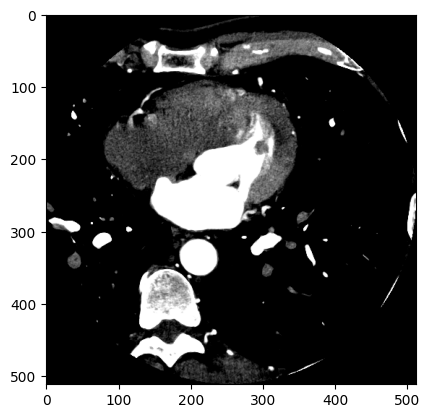

In [ ]:
f = np.array(images_seg)
print(f.shape)
print(images_seg[1].shape)

plt.imshow(images_files[146])

In [ ]:
import albumentations as A
import skimage

Blurred

In [ ]:
transform = A.Compose([A.Blur(always_apply=False, p=1.00, blur_limit=(3, 5))])

augmented_imgs=[]
augmented_masks=[]
for i in range(len(files)):
    #transformed = transform(image=np.squeeze(files[i,:,:,:]))
    transformed = transform(
        image=np.squeeze(images_files[i]),
        mask=np.squeeze(images_seg[i])
    )
    augmented_imgs.append(transformed["image"])
    augmented_masks.append(transformed["mask"])

#imgs_blurred=np.expand_dims(np.array(augmented_imgs).astype(int),axis=3)
imgs_blurred = np.array(augmented_imgs)
segs_blurred = np.array(augmented_masks)
#masks_blurred=masks_resized

In [ ]:
print(imgs_blurred.shape)
print(segs_blurred.shape)
#masks_blurred.shape

(640, 512, 512, 3)
(640, 512, 512, 3)


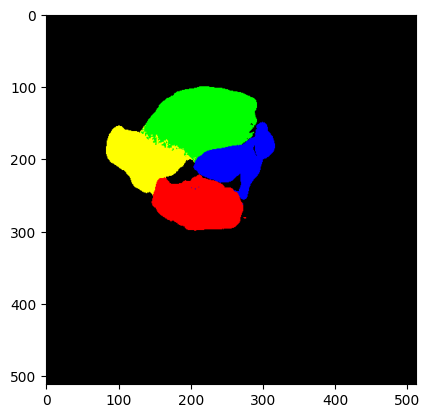

In [ ]:
plt.imshow(imgs_blurred[146])
plt.imshow(segs_blurred[146])  #caso de borroso, las mascaras no se tienen que cambiar

Horizontally flipped

In [ ]:
transform = A.Compose([A.HorizontalFlip(p=1)])

augmented_imgs=[]
augmented_masks=[]
for i in range(len(files)):
    transformed = transform(
      image=np.squeeze(images_files[i]),
      mask=np.squeeze(images_seg[i])
    )
    augmented_imgs.append(transformed["image"])
    augmented_masks.append(transformed["mask"])

imgs_flippedH=np.array(augmented_imgs)
masks_flippedH=np.array(augmented_masks)

In [ ]:
print(imgs_flippedH.shape)
print(masks_flippedH.shape)

(640, 512, 512, 3)
(640, 512, 512, 3)


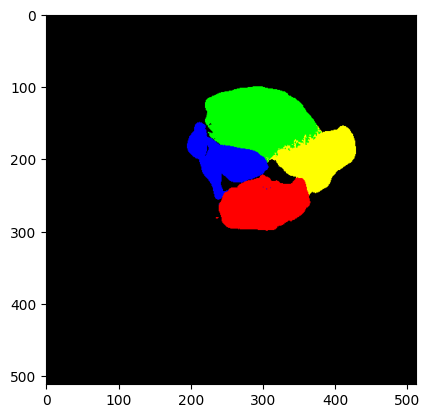

In [ ]:
plt.imshow(imgs_flippedH[146])
plt.imshow(masks_flippedH[146])

Vertically flipped

In [ ]:
transform = A.Compose([A.VerticalFlip(p=1)])

augmented_imgs=[]
augmented_masks=[]
for i in range(len(files)):
    transformed = transform(
      image=np.squeeze(images_files[i]),
      mask=np.squeeze(images_seg[i])
    )
    augmented_imgs.append(transformed["image"])
    augmented_masks.append(transformed["mask"])

imgs_flippedV=np.array(augmented_imgs)
masks_flippedV=np.array(augmented_masks)

In [ ]:
print(imgs_flippedV.shape)
print(masks_flippedV.shape)

(640, 512, 512, 3)
(640, 512, 512, 3)


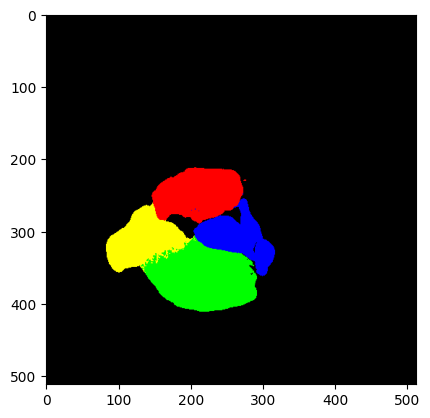

In [ ]:
plt.imshow(imgs_flippedV[146])
plt.imshow(masks_flippedV[146])

Angle flipped

In [ ]:
transform = A.Compose([A.Rotate(always_apply=False, p=1.0, limit=(-45, 45), interpolation=0, border_mode=1, value=None, mask_value=(0, 0, 0))])

augmented_imgs=[]
augmented_masks=[]
for i in range(len(files)):
    transformed = transform(
      image=np.squeeze(images_files[i]),
      mask=np.squeeze(images_seg[i])
    )
    augmented_imgs.append(transformed["image"])
    augmented_masks.append(transformed["mask"])

imgs_flipped=np.array(augmented_imgs)
masks_flipped=np.array(augmented_masks)

In [ ]:
print(imgs_flipped.shape)
print(masks_flipped.shape)

(640, 512, 512, 3)
(640, 512, 512, 3)


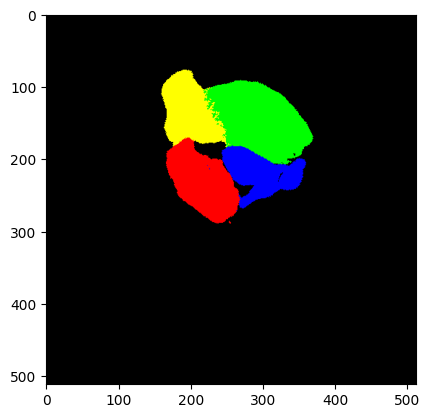

In [ ]:
plt.imshow(imgs_flipped[146])
plt.imshow(masks_flipped[146])

All transformation

In [ ]:
transform = A.Compose(
  [A.Rotate(always_apply=False, p=1.0, limit=(-45, 45), interpolation=0, border_mode=1, value=None, mask_value=(0, 0, 0)),
   #A.RandomSizedCrop(always_apply=False, p=1.0, min_max_height=(50, 95), height=127, width=127, w2h_ratio=1.0, interpolation=0),
   A.Blur(always_apply=False, p=1.0, blur_limit=(3, 5))]
)

augmented_imgs=[]
augmented_masks=[]
for i in range(len(files)):
    transformed = transform(
      image=np.squeeze(images_files[i]),
      mask=np.squeeze(images_seg[i])
    )
    augmented_imgs.append(transformed["image"])
    augmented_masks.append(transformed["mask"])

imgs_all=np.array(augmented_imgs)
masks_all=np.array(augmented_masks)

In [ ]:
print(imgs_all.shape)
print(masks_all.shape)

(640, 512, 512, 3)
(640, 512, 512, 3)


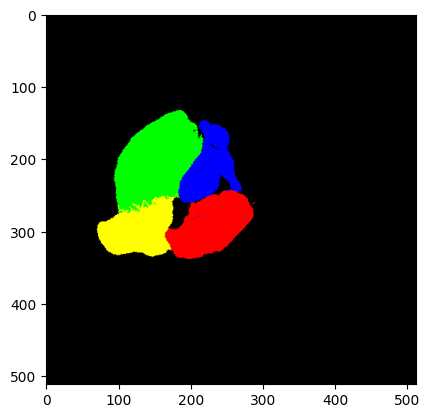

In [ ]:
plt.imshow(imgs_all[146])
plt.imshow(masks_all[146])

All transformation with probability 0.25

In [ ]:
transform = A.Compose(
  [A.Rotate(always_apply=False, p=0.35, limit=(-45, 45), interpolation=0, border_mode=1, value=None, mask_value=(0, 0, 0)),
   #A.RandomSizedCrop(always_apply=False, p=0.35, min_max_height=(50, 95), height=127, width=127, w2h_ratio=1.0, interpolation=0),
   A.Blur(always_apply=False, p=0.35, blur_limit=(3, 5))]
)

augmented_imgs=[]
augmented_masks=[]
length=len(files)
for j in range(2*len(files)):
    i=j%length
    transformed = transform(
      image=np.squeeze(images_files[i]),
      mask=np.squeeze(images_seg[i])
    )
    augmented_imgs.append(transformed["image"])
    augmented_masks.append(transformed["mask"])

imgs_all025=np.array(augmented_imgs)
masks_all025=np.array(augmented_masks)

In [ ]:
print(imgs_all025.shape)
print(masks_all025.shape)

(1280, 512, 512, 3)
(1280, 512, 512, 3)


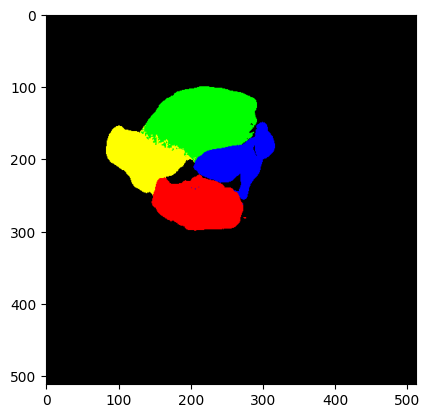

In [ ]:
plt.imshow(imgs_all025[146])
plt.imshow(masks_all025[146])

Creacion de los dataset con las imagenes augmented

In [ ]:
imgs_dataset = np.concatenate((imgs_blurred,imgs_flippedH,imgs_flippedV,imgs_flipped,imgs_all,imgs_all025))
masks_dataset = np.concatenate((segs_blurred,masks_flippedH,masks_flippedV,masks_flipped,masks_all,masks_all025))

print(imgs_dataset.shape)
print(masks_dataset.shape)

(4480, 512, 512, 3)
(4480, 512, 512, 3)


Guardar estos datasets augmented en input y output

In [ ]:
contador = 0
for img in imgs_dataset:
    ruta_salida = "D:/AnalisisDeDatosNoEstructurados/convnet/new_training/input/"+str(contador)+".png"

    # Guardar el array como imagen PNG
    plt.imsave(ruta_salida, img)
    contador+=1

In [ ]:
contador = 0
for mask in masks_dataset:
    ruta_salida = "D:/AnalisisDeDatosNoEstructurados/convnet/new_training/output/"+str(contador)+".png"

    # Guardar el array como imagen PNG
    plt.imsave(ruta_salida, mask)
    contador+=1

#### Cambio los nombres de las imagenes para que sigan un orden secuencial

In [ ]:
# Get the list of files in the folder
files = os.listdir(imagestr)

# Sort the files to ensure consistent order
files.sort()
base_name = "COR_"

counter = 0
# Iterate through the files and rename them
for file_name in files:
    # Generate the new file name
    new_name = f"{base_name}{counter:05d}"

    # Construct the full paths
    old_path = os.path.join(imagestr, file_name)
    new_path = os.path.join(imagestr, f"{new_name}{os.path.splitext(file_name)[1]}")

    # Rename the file
    os.rename(old_path, new_path)

    counter+=1

In [ ]:
# Get the list of files in the folder
files = os.listdir(labelstr)

# Sort the files to ensure consistent order
files.sort()
base_name = "COR_"

counter = 0
# Iterate through the files and rename them
for file_name in files:
    # Generate the new file name
    new_name = f"{base_name}{counter:05d}"

    # Construct the full paths
    old_path = os.path.join(labelstr, file_name)
    new_path = os.path.join(labelstr, f"{new_name}{os.path.splitext(file_name)[1]}")

    # Rename the file
    os.rename(old_path, new_path)

    counter+=1

-----------------------------------------------------------------------

------------------------------------------------------------------------

-------------------------------------------------------------------------------------------

# Preparacion para la red

In [4]:
imgs_train = os.listdir(imagestr)
masks_train = os.listdir(labelstr)

imgs_test = os.listdir(imagests)
masks_test = os.listdir(labelsts)

In [5]:
print(imgs_train)
print(masks_train)

['CORA_00004.png', 'CORA_00018.png', 'CORA_00005.png', 'CORA_00008.png', 'CORA_00007.png', 'CORA_00013.png', 'CORA_00014.png', 'CORA_00009.png', 'CORA_00015.png', 'CORA_00000.png', 'CORA_00017.png', 'CORA_00011.png', 'CORA_00002.png', 'CORA_00001.png', 'CORA_00006.png', 'CORA_00010.png', 'CORA_00016.png', 'CORA_00012.png', 'CORA_00003.png', 'CORA_00020.png', 'CORA_00051.png', 'CORA_00034.png', 'CORA_00025.png', 'CORA_00028.png', 'CORA_00050.png', 'CORA_00041.png', 'CORA_00039.png', 'CORA_00031.png', 'CORA_00048.png', 'CORA_00019.png', 'CORA_00038.png', 'CORA_00026.png', 'CORA_00040.png', 'CORA_00052.png', 'CORA_00027.png', 'CORA_00043.png', 'CORA_00030.png', 'CORA_00046.png', 'CORA_00021.png', 'CORA_00029.png', 'CORA_00042.png', 'CORA_00049.png', 'CORA_00024.png', 'CORA_00032.png', 'CORA_00045.png', 'CORA_00036.png', 'CORA_00022.png', 'CORA_00047.png', 'CORA_00037.png', 'CORA_00023.png', 'CORA_00044.png', 'CORA_00035.png', 'CORA_00033.png', 'CORA_00056.png', 'CORA_00063.png', 'CORA_000

In [6]:
imgs_train.sort()
masks_train.sort()

In [7]:
imgs_test.sort()
masks_test.sort()

In [8]:
print(imgs_train)
print(masks_train)

['CORA_00000.png', 'CORA_00001.png', 'CORA_00002.png', 'CORA_00003.png', 'CORA_00004.png', 'CORA_00005.png', 'CORA_00006.png', 'CORA_00007.png', 'CORA_00008.png', 'CORA_00009.png', 'CORA_00010.png', 'CORA_00011.png', 'CORA_00012.png', 'CORA_00013.png', 'CORA_00014.png', 'CORA_00015.png', 'CORA_00016.png', 'CORA_00017.png', 'CORA_00018.png', 'CORA_00019.png', 'CORA_00020.png', 'CORA_00021.png', 'CORA_00022.png', 'CORA_00023.png', 'CORA_00024.png', 'CORA_00025.png', 'CORA_00026.png', 'CORA_00027.png', 'CORA_00028.png', 'CORA_00029.png', 'CORA_00030.png', 'CORA_00031.png', 'CORA_00032.png', 'CORA_00033.png', 'CORA_00034.png', 'CORA_00035.png', 'CORA_00036.png', 'CORA_00037.png', 'CORA_00038.png', 'CORA_00039.png', 'CORA_00040.png', 'CORA_00041.png', 'CORA_00042.png', 'CORA_00043.png', 'CORA_00044.png', 'CORA_00045.png', 'CORA_00046.png', 'CORA_00047.png', 'CORA_00048.png', 'CORA_00049.png', 'CORA_00050.png', 'CORA_00051.png', 'CORA_00052.png', 'CORA_00053.png', 'CORA_00054.png', 'CORA_000

In [9]:
print(imgs_test)
print(masks_test)

['SE11_00051.png', 'SE11_00052.png', 'SE11_00053.png', 'SE11_00054.png', 'SE11_00055.png', 'SE11_00056.png', 'SE11_00057.png', 'SE11_00058.png', 'SE11_00059.png', 'SE11_00060.png', 'SE11_00061.png', 'SE11_00062.png', 'SE11_00063.png', 'SE11_00064.png', 'SE11_00065.png', 'SE11_00066.png', 'SE11_00067.png', 'SE11_00068.png', 'SE11_00069.png', 'SE11_00070.png', 'SE11_00071.png', 'SE11_00072.png', 'SE11_00073.png', 'SE11_00074.png', 'SE11_00075.png', 'SE11_00076.png', 'SE11_00077.png', 'SE11_00078.png', 'SE11_00079.png', 'SE11_00080.png', 'SE11_00081.png', 'SE11_00082.png', 'SE11_00083.png', 'SE11_00084.png', 'SE11_00085.png', 'SE11_00086.png', 'SE11_00087.png', 'SE11_00088.png', 'SE11_00089.png', 'SE11_00090.png', 'SE11_00091.png', 'SE11_00092.png', 'SE11_00093.png', 'SE11_00094.png', 'SE11_00095.png', 'SE11_00096.png', 'SE11_00097.png', 'SE11_00098.png', 'SE11_00099.png', 'SE11_00100.png', 'SE11_00101.png', 'SE11_00102.png', 'SE11_00103.png', 'SE11_00104.png', 'SE11_00105.png', 'SE11_001

In [10]:
imagenes_train = np.array([np.array(Image.open(join(imagestr, img))) for img in imgs_train])

In [11]:
imagenes_test = np.array([np.array(Image.open(join(imagests, img))) for img in imgs_test])

#### Preprocesamiento de Máscaras: las máscaras están a color, necesito convertirlas, mapear cada color único a una etiqueta de clase específica (blanco (255,255,255) clase 1, rojo (255,0,0) clase 2)...

In [12]:
def convert_color_masks_to_class_masks(color_mask):
    class_mask = np.zeros(color_mask.shape[:2], dtype=np.uint8)

    # Blanco -> Clase 1
    class_mask[np.all(color_mask == [255, 255, 255], axis=-1)] = 1
    # Rojo -> Clase 2
    class_mask[np.all(color_mask == [255, 0, 0], axis=-1)] = 2
    # Azul -> Clase 3
    class_mask[np.all(color_mask == [0, 0, 255], axis=-1)] = 3
    # Verde -> Clase 4
    class_mask[np.all(color_mask == [0, 255, 0], axis=-1)] = 4
    # Amarillo -> Clase 5
    class_mask[np.all(color_mask == [255, 255, 0], axis=-1)] = 5
    # Naranja -> Clase 6
    class_mask[np.all(color_mask == [239, 127, 26], axis=-1)] = 6
    # Cyan -> Clase 7
    class_mask[np.all(color_mask == [0, 255, 255], axis=-1)] = 7

    return class_mask

In [13]:
mascaras_train = np.array([convert_color_masks_to_class_masks(np.array(Image.open(join(labelstr, mask)))) for mask in masks_train])

In [14]:
mascaras_test = np.array([convert_color_masks_to_class_masks(np.array(Image.open(join(labelsts, mask)))) for mask in masks_test])

In [ ]:
print(masks_train[4000])
print(np.unique(mascaras_train[4000]))

COR_04600.png
[0 1 2 3 4 5 7]


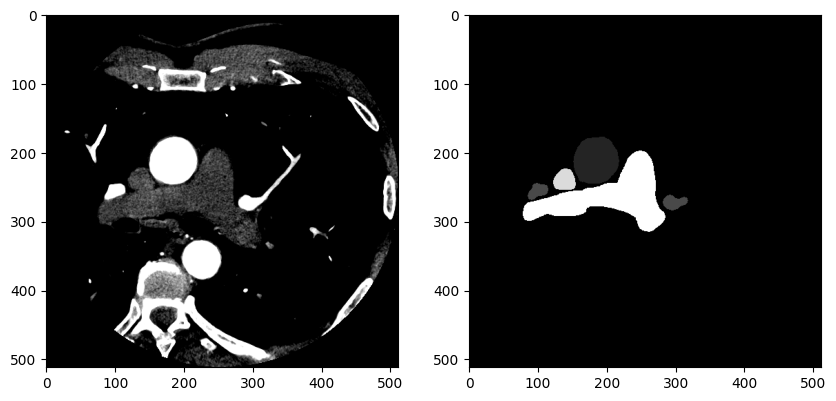

In [15]:
plt.figure(figsize=(10, 5))

# Imagen train
plt.subplot(1, 2, 1)
plt.imshow(imagenes_train[10], cmap='gray')

# Máscara train
plt.subplot(1, 2, 2)
plt.imshow(mascaras_train[10], cmap='gray')

plt.show()

In [16]:
print("Forma de las imágenes de entrenamiento:", imagenes_train.shape)
print("Tipo de datos de las imágenes de entrenamiento:", imagenes_train.dtype)
print("Forma de las máscaras de entrenamiento:", mascaras_train.shape)
#print("Forma de las máscaras de entrenamiento 2:", mascaras_train2.shape)
print("Tipo de datos de las máscaras:", mascaras_train.dtype)
print("Valores únicos en las máscaras (deberían estar en el rango correcto):", np.unique(mascaras_train))

print("-------------------------------------------------------------------")

print("Forma de las imágenes de test:", imagenes_test.shape)
print("Tipo de datos de las imágenes de test:", imagenes_test.dtype)
print("Forma de las máscaras de test:", mascaras_test.shape)
print("Tipo de datos de las máscaras:", mascaras_test.dtype)
print("Valores únicos en las máscaras (deberían estar en el rango correcto):", np.unique(mascaras_test))

Forma de las imágenes de entrenamiento: (640, 512, 512)
Tipo de datos de las imágenes de entrenamiento: uint8
Forma de las máscaras de entrenamiento: (640, 512, 512)
Tipo de datos de las máscaras: uint8
Valores únicos en las máscaras (deberían estar en el rango correcto): [0 1 2 3 4 5 6 7]
-------------------------------------------------------------------
Forma de las imágenes de test: (149, 512, 512)
Tipo de datos de las imágenes de test: uint8
Forma de las máscaras de test: (149, 512, 512)
Tipo de datos de las máscaras: uint8
Valores únicos en las máscaras (deberían estar en el rango correcto): [0 1 2 3 4 5 6 7]


# U-Net propuesta


Funcionamiento de la arquitectura U-Net con una hipotética imagen de un corazón de 512x512 píxeles y su correspondiente máscara con 8 clases segmentando los elementos del corazón.

#### Paso 1: Entrada
- Imagen de Entrada: Tenemos una imagen de un corazón de 512x512 píxeles. Esta imagen es procesada por la capa de entrada de la red U-Net.

#### Paso 2: Downsampling o Codificación
Durante esta fase, la red comienza a entender y codificar el contexto de la imagen (en este caso, las diferentes partes y características del corazón) reduciendo progresivamente su resolución espacial pero aumentando la profundidad (cantidad de filtros), lo que nos permite capturar características más abstractas y globales.

1. Primera Capa Conv2D y MaxPooling: Las primeras capas convolucionales aplican 64 filtros para detectar características básicas como bordes o curvas. Después del pooling, la imagen tiene una resolución de 256x256 píxeles. (MaxPooling(2,2) --> de 512 a 256)
2. Segunda Capa Conv2D y MaxPooling: Esta fase utiliza 128 filtros y después del pooling, la imagen se reduce a 128x128 píxeles (MaxPooling(2,2) --> de 256 a 128). Aquí, la red empieza a reconocer patrones más complejos, como la forma del corazón y sus grandes componentes.

#### Paso 3: Bottleneck
Esta es la fase más profunda, donde la red tiene la capacidad de aprender las características más críticas y detalladas del corazón, aún con una resolución reducida (128x128 píxeles después del último MaxPooling). Aquí, con 256 filtros, la red puede identificar las diferencias sutiles entre las diversas partes del corazón que son cruciales para una segmentación precisa.

#### Paso 4: Upsampling o Decodificación
Ahora, la red comienza a reconstruir la imagen desde las características codificadas, aumentando su resolución mientras fusiona la información aprendida durante el downsampling para asegurar que los detalles finos no se pierdan.

1. Primera Capa de Upsampling: La imagen se aumenta de 128x128 a 256x256 píxeles (con Conv2DTranspose(2,2) --> de 128 a 256). Se concatenan las características aprendidas durante el downsampling correspondientes para mantener los detalles.
2. Segunda Capa de Upsampling: Continúa el proceso hasta restaurar la imagen a su tamaño original de 512x512 píxeles (con Conv2DTranspose(2,2) --> de 256 a 512). En este punto, la red ha aprendido a distinguir entre las diferentes partes del corazón.

#### Paso 5: Salida
- Capa de Salida: Finalmente, una capa convolucional ajusta el número de canales de salida al número de clases (8 en este caso). La activación softmax asegura que cada píxel de la imagen de salida representa la probabilidad de pertenecer a cada una de las 8 clases segmentando los diferentes elementos del corazón (por ejemplo, las cámaras del corazón, las válvulas, los grandes vasos, etc.).

#### Resultado
La imagen de salida será una segmentación semántica del corazón, donde cada píxel está clasificado en una de las 8 clases predefinidas, proporcionando una máscara detallada que identifica las distintas partes del corazón. Esto es especialmente útil en aplicaciones médicas, donde tales segmentaciones precisas pueden ayudar en el diagnóstico y tratamiento de condiciones cardíacas.

In [17]:
#def unet_model(input_size=(512, 512, 3), num_classes=8):
def unet_model(input_size=(512, 512, 1), num_classes=8):
    inputs = layers.Input(input_size)

    # Downsampling --> Capturar contexto de la imagen
        #Conv2D (64 filtros): Aplica 64 filtros convolucionales de tamaño 3x3 a la imagen de entrada. La activación ReLU se utiliza para introducir
            #no linealidades. La inicialización de He y el padding 'same' mantienen el tamaño de la imagen.
        #Dropout (0.1): Se descartan aleatoriamente el 10% de las características para reducir el sobreajuste.
        #Conv2D (64 filtros): Otra capa convolucional similar a la anterior para extraer más características.
        #MaxPooling2D: Reduce a la mitad las dimensiones espaciales (ancho y alto) de la imagen, concentrándose en las características más prominentes.
        #Este proceso se repite con 128 filtros después del primer MaxPooling, profundizando en la red y reduciendo aún más las dimensiones espaciales.
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1) #aplica la operación de convolución a c1 y devuelve el resultado, que puede ser asignado a otra variable, en este caso sobrescribe c1
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bottleneck --> Se reduce aún más la dimensionalidad pero aumentando la profundidad (número de canales o filtros) para capturar
                    #la información más crítica.
        #Conv2D (256 filtros): Incrementa la capacidad de la red para aprender características complejas con una cantidad mayor de filtros. El dropout aquí es del 20% para mejorar la generalización.
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c5 = layers.Dropout(0.2)(c5)
    c5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Upsampling --> Se enfoca en reconstruir la imagen a partir de las características codificadas, aumentando la resolución espacial.
        #Conv2DTranspose (128 filtros): También conocida como deconvolución o convolución transpuesta. Esta capa aumenta el tamaño de la imagen
            #para prepararla para la concatenación con las características correspondientes de la fase de codificación (downsampling).
        #Concatenate: Fusiona las características de la fase de codificación con las de la fase de decodificación para recuperar la información perdida durante el downsampling.
        #Conv2D (128 filtros): Procesa las características combinadas para refinar los detalles de la imagen.
        #Este proceso de upsampling y concatenación se repite, disminuyendo el número de filtros a 64, para seguir reconstruyendo la imagen hacia su resolución original.
    u6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c2])
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c1], axis=3)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    # Salida
        #Conv2D (num_classes): La capa final de convolución ajusta el número de canales de salida al número de clases deseado. La activación 'softmax'
        #se utiliza para obtener una probabilidad por clase en cada píxel, lo que es útil para tareas de segmentación semántica.
    outputs = layers.Conv2D(num_classes, (1, 1), activation='softmax')(c7)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [18]:
model = unet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

La variable history que obtenemos como resultado de model.fit() no es un modelo en sí, sino un objeto que contiene los datos del historial del proceso de entrenamiento. Esta información incluye cosas como la precisión del modelo y la pérdida en cada época para el conjunto de entrenamiento y el conjunto de validación. Solo guarda datos estadísticos del entrenamiento y no la arquitectura del modelo, los pesos aprendidos, o la configuración del optimizador. Su propósito principal es permitirte analizar el proceso de entrenamiento (por ejemplo, visualizando la mejora de la precisión o la reducción de la pérdida a lo largo de las épocas).

## LLevar modelo a la gpu

In [ ]:
model.to(device)

In [ ]:
history = model.fit(imagenes_train, mascaras_train, batch_size=8, epochs=25, validation_split=0.1)

Epoch 1/25
72/72 [==============================] - 104s 1s/step - loss: 0.3163 - accuracy: 0.9310 - val_loss: 0.2657 - val_accuracy: 1.0000
Epoch 2/25
72/72 [==============================] - 105s 1s/step - loss: 0.2866 - accuracy: 0.9331 - val_loss: 0.1811 - val_accuracy: 1.0000
Epoch 3/25
72/72 [==============================] - 104s 1s/step - loss: 0.2683 - accuracy: 0.9334 - val_loss: 0.2035 - val_accuracy: 1.0000
Epoch 4/25
72/72 [==============================] - 105s 1s/step - loss: 0.2459 - accuracy: 0.9335 - val_loss: 0.1850 - val_accuracy: 1.0000
Epoch 5/25
72/72 [==============================] - 107s 1s/step - loss: 0.2395 - accuracy: 0.9335 - val_loss: 0.1782 - val_accuracy: 1.0000
Epoch 6/25
72/72 [==============================] - 107s 1s/step - loss: 0.2293 - accuracy: 0.9335 - val_loss: 0.1254 - val_accuracy: 1.0000
Epoch 7/25
72/72 [==============================] - 105s 1s/step - loss: 0.2227 - accuracy: 0.9335 - val_loss: 0.1886 - val_accuracy: 1.0000
Epoch 8/25
72

In [ ]:
model.save('UNet_scratch_grises_simple.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Cargar el modelo
#model = load_model('D:/AnalisisDeDatosNoEstructurados/convnet/intento3/UNet_scratch_grises_75epochs.h5')
model = load_model('/content/drive/MyDrive/UNet_scratch_grises_75epochs.h5')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

NameError: name 'history' is not defined

Progreso de Aprendizaje: El modelo está aprendiendo ya que ambas métricas, precisión y pérdida, están mejorando a lo largo de las épocas.

Posible Sobreajuste: Hay algunas señales de que el modelo podría estar comenzando a sobreajustarse, dado que la precisión de validación tiene fluctuaciones significativas. Esto significa que el modelo podría estar aprendiendo patrones específicos de los datos de entrenamiento que no generalizan bien a datos no vistos.

Regularización: Podríamos considerar el aumento de datos (data augmentation) para prevenir problemas de sobreajuste.

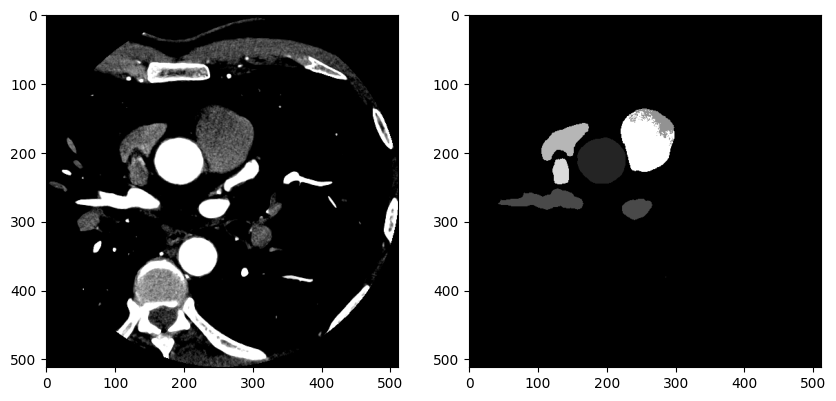

In [19]:
plt.figure(figsize=(10, 5))

# Imagen test
plt.subplot(1, 2, 1)
plt.imshow(imagenes_test[10], cmap='gray')

# Máscara test
plt.subplot(1, 2, 2)
plt.imshow(mascaras_test[10], cmap='gray')

plt.show()

In [20]:
predictions = model.predict(imagenes_test)

5/5 [==============================] - 72s 8s/step


In [21]:
predicted_classes = np.argmax(predictions, axis=-1) # Obtener las clases predichas

Comparacion de pixeles

In [22]:
print(mascaras_test.shape)
print(predicted_classes.shape)

print("----------------------------------------")

print(np.unique(mascaras_test[50]))
print(np.unique(predicted_classes[50]))

(149, 512, 512)
(149, 512, 512)
----------------------------------------
[0 1 2 3 4 5 7]
[0 1 2 3 4 5]


Comparacion visual

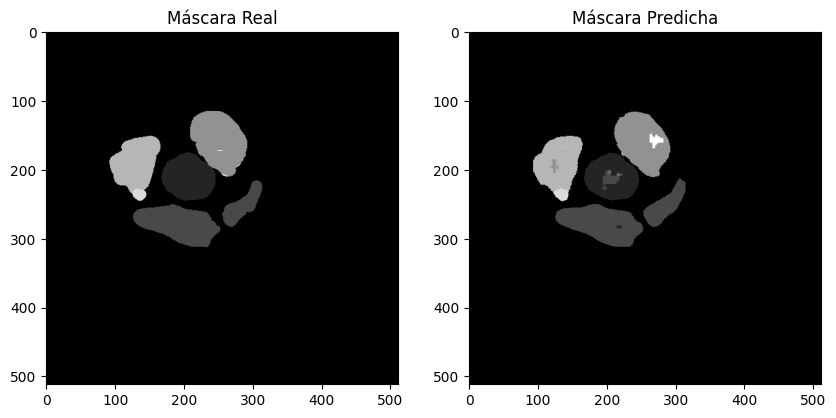

In [23]:
# Dibujo de la máscara real y la máscara predicha en subplots
plt.figure(figsize=(10, 5))

# Máscara real
plt.subplot(1, 2, 1)
plt.imshow(mascaras_test[30], cmap='gray')
plt.title('Máscara Real')

# Máscara predicha
plt.subplot(1, 2, 2)
plt.imshow(predicted_classes[30], cmap='gray')
plt.title('Máscara Predicha')

plt.show()

In [24]:
accuracy = np.mean(predicted_classes == mascaras_test)
print(f"Pixel Accuracy: {accuracy:.4f}")

Pixel Accuracy: 0.9914


In [25]:
test_loss, test_acc = model.evaluate(imagenes_test, mascaras_test)
print(f"Test Accuracy: {test_acc}")

5/5 [==============================] - 6s 1s/step - loss: 0.0214 - accuracy: 0.9914
Test Accuracy: 0.9913938641548157


# Utilizar modelo pre-entrenado y descongelar capas

Utilizo un modelo pre-entrenado de cerebros de hugging face. Solo quiero utilizar su parte convolucional, y con sus pesos congelados para que cuando le enseñe mi dataset de corazones aprenda nuevas features de este. Una vez hecho eso, puedo descongelar capas de la parte convolucional para ir viendo la mejora (fine tuning)

In [19]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return 1 - (numerator + 1) / (denominator + 1)

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [20]:
with custom_object_scope({'dice_loss': dice_loss, 'dice_coef': dice_coef}):
    full_model = load_model('/content/drive/MyDrive/model.h5')

In [ ]:
# Carga del modelo preentrenado
#model_path = 'D:/AnalisisDeDatosNoEstructurados/convnet/pre-trained brain model/model.h5'
model_path = '/content/drive/MyDrive/model.h5'
full_model = load_model(model_path)

In [21]:
# Congela las capas del modelo para hacer feature extraction
for layer in full_model.layers:
    layer.trainable = False

In [22]:
# Muestra la arquitectura del modelo
full_model.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0][0]

El summary nos dice que la última capa convolucional del modelo (usualmente antes de cualquier capa Flatten o Dense) en la cual realizar feature extraction es la capa conv2d_9 (None, 16, 16, 1024)

### Hago feature extraction de mi dataset con la parte convolucional del modelo pre entrenado (predict)

In [23]:
# Cortar el modelo hasta la capa específica
conv_base = Model(inputs=full_model.inputs,
                  outputs=full_model.get_layer('activation_9').output)

# Verificar la estructura para asegurar que termina en la capa correcta
#conv_base.summary()

El modelo acepta imagenes (256,256,3) y tenemos (512, 512, 1)

In [24]:
def feature_extraction(image_path):
  # Carga la imagen en escala de grises
  img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

  # Convierte la imagen de escala de grises a RGB
  img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

  # Redimensiona la imagen a 256x256
  img_resized = cv2.resize(img_rgb, (256, 256))

  # Normaliza la imagen
  img_normalized = img_resized / 255.0

  # Expande las dimensiones para adaptar al input del modelo: (None, 256, 256, 3)
  img_expanded = np.expand_dims(img_normalized, axis=0)

  # Extraer características
  feature = conv_base.predict(img_expanded)

  return feature

In [25]:
train_features = []
for img_filename in imgs_train:
    image_path = os.path.join(imagestr, img_filename)
    feature = feature_extraction(image_path)
    train_features.append(feature.flatten())  # Aplanar el array y agregar al vector de características
    #train_features.append(feature)

1/1 [==============================] - 0s 18ms/step


In [26]:
test_features = []
for img_filename in imgs_test:
    image_path = os.path.join(imagests, img_filename)
    feature = feature_extraction(image_path)
    test_features.append(feature.flatten())  # Aplanar el array y agregar al vector de características

1/1 [==============================] - 0s 18ms/step


In [27]:
  train_features = np.array(train_features)
  test_features = np.array(test_features)

### Creo nuevo modelo, parte convolucional del pre-entrenado y parte deconvolucional del mio

Para unir la parte convolucional que extrajimos del modelo U-Net original (hasta activation_9) con la parte deconvolucional del modelo nuestro, necesitamos modificar ligeramente la arquitectura para asegurarnos que las dimensiones y los canales de las capas coincidan adecuadamente en los puntos de concatenación.

In [28]:
# Starting from the output of the last convolutional layer in the base model
inputs = conv_base.output

# Primera etapa de deconvolución
u6_n = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(inputs)  # Tamaño sube a (None, 32, 32, 512)
u6_n = layers.concatenate([u6_n, full_model.get_layer('activation_7').output])  # Necesita coincidir en (None, 32, 32, x)

c6_n = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6_n)
c6_n = layers.Dropout(0.2)(c6_n)
c6_n = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6_n)

# Segunda etapa de deconvolución
u7_n = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6_n)  # Tamaño sube a (None, 64, 64, 256)
u7_n = layers.concatenate([u7_n, full_model.get_layer('activation_5').output])  # Necesita coincidir en (None, 64, 64, x)

c7_n = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7_n)
c7_n = layers.Dropout(0.2)(c7_n)
c7_n = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7_n)

# Tercera etapa de deconvolución
u8_n = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7_n)  # Tamaño sube a (None, 128, 128, 128)
u8_n = layers.concatenate([u8_n, full_model.get_layer('activation_3').output])  # Correcta skip connection

c8_n = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8_n)
c8_n = layers.Dropout(0.2)(c8_n)
c8_n = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8_n)

# Cuarta etapa de deconvolución
u9_n = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8_n)  # Tamaño sube a (None, 256, 256, 64)
u9_n = layers.concatenate([u9_n, full_model.get_layer('activation_1').output])  # Correcta skip connection

c9_n = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9_n)
c9_n = layers.Dropout(0.2)(c9_n)
c9_n = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9_n)

# Capa de salida
outputs = layers.Conv2D(8, (1, 1), activation='softmax')(c9_n)  # Ajusta el número de clases si es necesario (num_classes=8)

# Crear el modelo final U-Net modificando el modelo pre-entrenado
final_model = models.Model(inputs=full_model.input, outputs=outputs)

In [29]:
final_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Resumen del modelo final para verificar la arquitectura
final_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_normalization[0]

In [30]:
print(train_features.shape)
print(mascaras_train.shape)

(640, 262144)
(640, 512, 512)


In [31]:
# Asumiendo que train_features está aplanado para imágenes de 512x512
train_images = train_features.reshape((640, 512, 512))

train_images_rgb = train_images[:, ::2, ::2]

# Convertimos las imágenes de escala de grises a RGB replicando los valores en tres canales
train_images_resized = np.repeat(train_images_rgb[:,:,:,np.newaxis], 3, axis=-1)

In [ ]:
def apply_mask_conversion(masks):
    # Aplica la función de conversión a cada máscara
    class_masks = np.array([convert_color_masks_to_class_masks(mask) for mask in masks])
    return class_masks

train_masks = mascaras_train.reshape((640, 512, 512, 1))

# Primero, debemos asegurarnos de que tus máscaras estén en el formato correcto y tamaño antes de aplicar 'convert_color_masks_to_class_masks'
# Si tus máscaras originales son coloridas y del tamaño 512x512, redimensiona primero:
train_masks_resized = np.array([img_to_array(array_to_img(m, scale=False).resize((256, 256))) for m in train_masks])

# Aplicar la función a todas las máscaras
class_masks = apply_mask_conversion(train_masks_resized)

# Convertir a one-hot encoding
train_masks_one_hot = to_categorical(class_masks, num_classes=8)

In [32]:
# Comprobación de dimensiones
print("Dimensiones de imágenes de entrenamiento:", train_images_resized.shape)
print("Dimensiones de las máscaras de clase:", class_masks.shape)
print("Dimensiones de las máscaras en one-hot:", train_masks_one_hot.shape)

Dimensiones de imágenes de entrenamiento: (640, 256, 256, 3)
Dimensiones de las máscaras de clase: (640, 256, 256)
Dimensiones de las máscaras en one-hot: (640, 256, 256, 8)


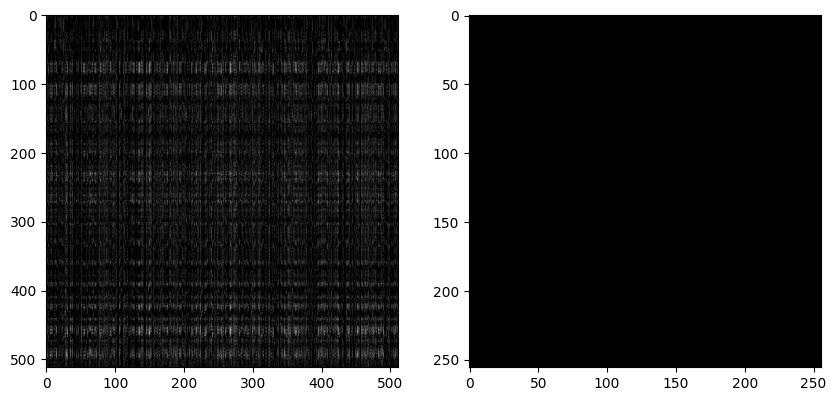

In [51]:
plt.figure(figsize=(10, 5))

# Imagen train
plt.subplot(1, 2, 1)
plt.imshow(train_images[10], cmap='gray')

# Máscara train
plt.subplot(1, 2, 2)
plt.imshow(class_masks[10], cmap='gray')

plt.show()

In [33]:
history = final_model.fit(train_images_resized, train_masks_one_hot, batch_size=8, epochs=25, validation_split=0.1)

Epoch 1/25
72/72 [==============================] - 52s 383ms/step - loss: 0.0383 - accuracy: 0.9865 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/25
72/72 [==============================] - 27s 374ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/25
72/72 [==============================] - 27s 378ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/25
72/72 [==============================] - 27s 380ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/25
72/72 [==============================] - 28s 383ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/25
72/72 [==============================] - 28s 384ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/25
72/72 [==============================] - 28s 385ms/step - loss: 0.0000e+00 - accuracy: 

In [34]:
final_model.save('UNet_final_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Cargar el modelo
final_model = load_model('/content/drive/MyDrive/UNet_final_model.h5')

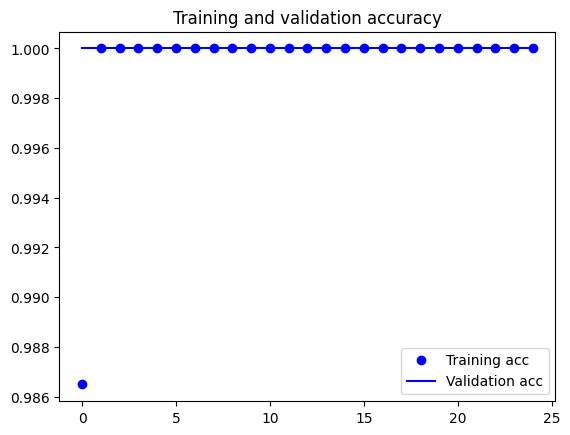

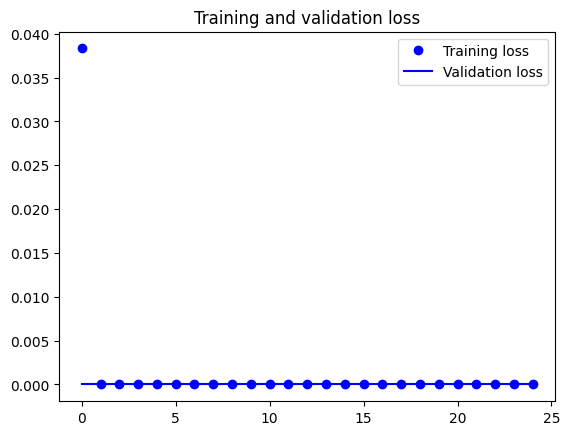

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
# Asumiendo que train_features está aplanado para imágenes de 512x512
test_images = imagenes_test.reshape((149, 512, 512))

test_images_rgb = test_images[:, ::2, ::2]

# Convertimos las imágenes de escala de grises a RGB replicando los valores en tres canales
test_images_resized = np.repeat(test_images_rgb[:,:,:,np.newaxis], 3, axis=-1)

print(test_images_resized.shape)

(149, 256, 256, 3)


In [43]:
predictions = final_model.predict(test_images_resized)

5/5 [==============================] - 43s 5s/step


In [44]:
predicted_classes = np.argmax(predictions, axis=-1) # Obtener las clases predichas

In [45]:
print(mascaras_test.shape)
print(predicted_classes.shape)

print("----------------------------------------")

print(np.unique(mascaras_test[50]))
print(np.unique(predicted_classes[50]))

(149, 512, 512)
(149, 256, 256)
----------------------------------------
[0 1 2 3 4 5 7]
[0]


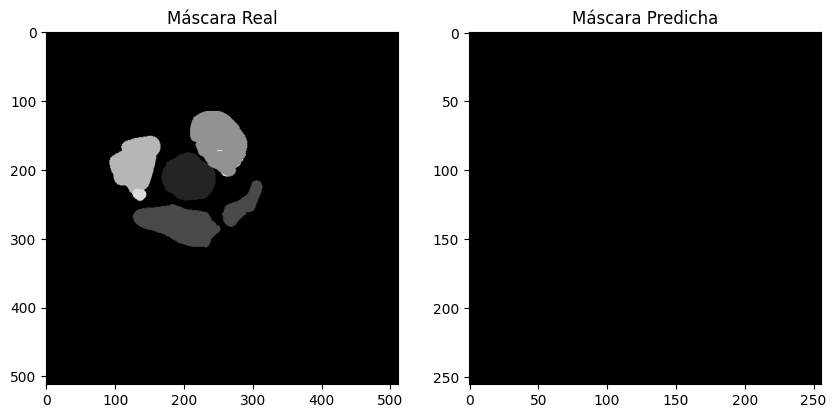

In [46]:
# Dibujo de la máscara real y la máscara predicha en subplots
plt.figure(figsize=(10, 5))

# Máscara real
plt.subplot(1, 2, 1)
plt.imshow(mascaras_test[30], cmap='gray')
plt.title('Máscara Real')

# Máscara predicha
plt.subplot(1, 2, 2)
plt.imshow(predicted_classes[30], cmap='gray')
plt.title('Máscara Predicha')

plt.show()

In [47]:
accuracy = np.mean(predicted_classes == mascaras_test)
print(f"Pixel Accuracy: {accuracy:.4f}")

ValueError: operands could not be broadcast together with shapes (149,256,256) (149,512,512) 

In [ ]:
test_loss, test_acc = model.evaluate(imagenes_test, mascaras_test)
print(f"Test Accuracy: {test_acc}")

In [ ]:
# Descongelar las capas superiores del modelo base
for layer in conv_base.layers[-10:]:  # Ejemplo: descongelar las últimas 10 capas
    layer.trainable = True

# Recompilar el modelo para que los cambios surtan efecto
final_model.compile(optimizer=Adam(learning_rate=1e-5),  # Un learning rate más pequeño
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# Continuar el entrenamiento para fine-tuning
history_fine = final_model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,  # El fine-tuning puede requerir más épocas
    validation_data=val_generator,
    validation_steps=50)

------------------------------------

----------------------------------------------

-----------------------------------------------

--------------------------------------------

In [48]:
print(train_features.shape)
print(mascaras_train.shape)

(640, 512, 512)
(640, 512, 512)


In [44]:
# Asegúrate de tener tus datos cargados en train_features y masks_train
# Por ejemplo, si train_features originalmente está aplanado en (640, 262144)
train_features_pre = train_features.reshape(-1, 512, 512)  # Redimensiona a (640, 512, 512)

# Crear un contenedor para las características redimensionadas en RGB
train_features_resized = np.zeros((train_features_pre.shape[0], 256, 256, 3))

# Redimensionar cada imagen y duplicar a 3 canales
for i in range(train_features.shape[0]):
    # Asegura que cada imagen tiene una dimensión extra para cumplir con los requisitos de tf.image.resize()
    resized_img = tf.image.resize(train_features[i][..., np.newaxis], (256, 256)).numpy()
    # Duplica los canales para convertir de escala de grises a RGB
    train_features_resized[i] = np.repeat(resized_img, 3, axis=-1)

print(train_features_resized.shape)

(640, 256, 256, 3)


In [47]:
# Asumiendo que masks_train tiene la forma original (640, 512, 512)
masks_train_resized = np.zeros((mascaras_train.shape[0], 256, 256, 1))

# Redimensionar las máscaras
for i in range(masks_train.shape[0]):
    masks_train_resized[i, ..., 0] = tf.image.resize(masks_train[i][..., np.newaxis], (256, 256), method='nearest').numpy()

AttributeError: 'list' object has no attribute 'shape'

In [46]:
masks_train_resized = np.array(masks_train_resized)

NameError: name 'masks_train_resized' is not defined

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

# Assuming your images are of a standard size, e.g., 256x256 pixels
input_shape = (256, 256, 3)  # Adjust based on your actual image size and channels (e.g., RGB)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))

# Upsampling layers
model.add(layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same'))
model.add(layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))

# Output layer
model.add(layers.Conv2D(8, (1, 1), activation='softmax'))  # Output for 8 classes

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()
